In [1]:
import pandas as pd

In [2]:
txt = open("ar_cations.txt", "r")

In [3]:
lines = txt.readlines()

In [4]:
lines[555].split('\t')

['1508269285_6c5723f67d.jpg#0', 'الكلب يقف في الماء بجانب العشب\n']

In [5]:
image = lines[555].split('\t')[0].split("#")[0]; image

'1508269285_6c5723f67d.jpg'

In [6]:
line = lines[0].split('\t')[1].strip(); line

'طفلة صغيرة تتسلق إلى مسرح خشبي'

In [7]:
import pyarabic.araby as araby

In [8]:
araby.tokenize(line)

['طفلة', 'صغيرة', 'تتسلق', 'إلى', 'مسرح', 'خشبي']

In [9]:
images, captions = [], []
for line in lines:
    images.append(line.split('\t')[0].split("#")[0])
    captions.append(line.split('\t')[1].strip())

In [10]:
images[:4], captions[:4]

(['1000268201_693b08cb0e.jpg',
  '1001773457_577c3a7d70.jpg',
  '1002674143_1b742ab4b8.jpg',
  '1003163366_44323f5815.jpg'],
 ['طفلة صغيرة تتسلق إلى مسرح خشبي',
  'كلب أسود وكلب ثلاثي الألوان يلعبان مع بعضهما البعض على الطريق',
  'فتاة صغيرة مغطاة بالطلاء تجلس أمام قوس قزح',
  'رجل يجلس على مقعد بينما يجلس كلبه بجانبه'])

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import spacy

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [12]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.freq_threshold = freq_threshold
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize_en(text):
        return [tok.lower() for tok in araby.tokenize(text)]
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize_en(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    def numericalize(self, text):
        tokenizd_text = self.tokenize_en(text)
        
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] 
                for token in tokenizd_text]

In [13]:
vocab = Vocabulary()
vocab.build_vocabulary(captions)

In [14]:
[vocab.itos[i] for i in vocab.numericalize(captions[1])]

['كلب',
 'أسود',
 'وكلب',
 'ثلاثي',
 'الألوان',
 'يلعبان',
 'مع',
 'بعضهما',
 'البعض',
 'على',
 'الطريق']

In [15]:
captions[1]

'كلب أسود وكلب ثلاثي الألوان يلعبان مع بعضهما البعض على الطريق'

In [16]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, transform=None, freq_threshold=2):
        self.root_dir = root_dir
        self.transform = transform
        
        self.imgs = images
        self.captions = captions
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions)
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(self.root_dir+'/images/'+img_id).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [17]:
ds = FlickrDataset("flickr/")

'<SOS> كلب أسود وكلب ثلاثي الألوان يلعبان مع بعضهما البعض على الطريق <EOS>'

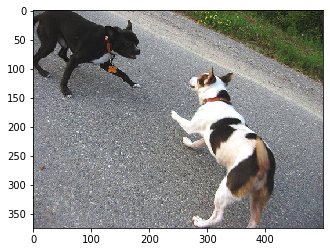

In [18]:
plt.imshow(ds[1][0]);
' '.join([ds.vocab.itos[i.item()] for i in ds[1][1]])

In [19]:
pad_idx = ds.vocab.stoi["<PAD>"]

In [20]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
        
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=pad_idx)
        
#         print(imgs.shape)
#         print(targets.shape)
        return imgs, targets

In [21]:
class EncoderCNN(nn.Module):
    def __init__(self, hid_dim, dropout, train_cnn=False):
        super().__init__()
        
        self.hid_dim = hid_dim        
        self.train_cnn = train_cnn
        
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, hid_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, images):
        features = self.dropout(self.relu(self.inception(images)))
        return features

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim, vocab_sz, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.vocab_sz = vocab_sz
        
        self.embedding = nn.Embedding(vocab_sz, emb_dim)
        
        # GRU: inputs-> [embeddings + context], output -> hidden, output
        self.rnn = nn.GRU(emb_dim+hid_dim, hid_dim)
        
        # FC: inputs:-> [embeddings + context + output]
        self.fc_out = nn.Linear(emb_dim + hid_dim*2, vocab_sz)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, context):
        #input = [batch size]
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
#         print(f'Context shape {context.shape}')
#         print(f'embeded shape {embedded.shape}')
        
        emb_con = torch.cat((embedded, context), dim=2)
        #emb_con = [1, batch size, emb_dim + hid_dim]
        
#         print(f"Hidden shape {hidden.shape}")
#         print(f"embedded shape {embedded.shape}")
#         print(f"context shape {context.shape}")
#         print(f"emb_con shape {emb_con.shape}")
#         print('_'*22)
        
        output, hidden = self.rnn(emb_con, hidden)
        #output = [1, batch size, hid dim] -> seq len and n directions = 1
        #hidden = [1, batch size, hid dim] -> n layers and n directions =1
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim=1)
        #output = [batch size, emb_dim + hid_dim*2]
        
        predictions = self.fc_out(output)
        #predictions = [batch size, vocab size]
        
        return predictions, hidden

In [42]:
###
### No teacher forcing for now
###
class Img2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert self.encoder.hid_dim == self.decoder.hid_dim,\
            'The hid dim of the context vector must equal the hid dim of the decoder !!'
            
    def forward(self, img, trg):
        #src = [batch size, 3, 224, 224]
        #trg = [trg len, batch size]
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.vocab_sz
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        context = self.encoder(img)
        context = context.unsqueeze(0)
        hidden = context
        
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            
            outputs[t] = output
            
            top1 = output.argmax(1)
            
            input = top1
            
        return outputs

In [43]:
HID_DIM = 256
EMB_DIM = 256
DROPOUT = .5
VOCAB_LENGTH = len(ds)
TRAIN_CNN = False
bs = 265
lr = 3e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = EncoderCNN(HID_DIM, DROPOUT)
dec = DecoderRNN(EMB_DIM, HID_DIM, VOCAB_LENGTH, DROPOUT)

model = Img2Seq(enc, dec, device).to(device)

In [44]:
criterion = nn.CrossEntropyLoss(ignore_index=ds.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=lr)

# only finetune the CNN
for name, param in model.encoder.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = TRAIN_CNN

In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,317,379 trainable parameters


In [46]:
# transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [28]:
train_loader = DataLoader(
    dataset=FlickrDataset("flickr/", transform),
    batch_size=bs,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
    collate_fn=MyCollate(pad_idx=pad_idx),
    drop_last=True
)

In [29]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for idx, (imgs, captions) in tqdm(
        enumerate(iterator), total=len(iterator), leave=False
    ):
        
        optimizer.zero_grad()
        
        imgs = imgs.to(model.device)
        captions = captions.to(model.device)
        
        output = model(imgs, captions)
        
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        #flattening the output and target + ignoring <sos>
        output = output[1:].view(-1, output_dim)
        trg = captions[1:].view(-1)
        
        #trg = [(trg len -1) * batch size]
        #output = [(trg len -1) * batch size, output dim]
        
        
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
import torch
from tqdm import tqdm,trange
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [32]:
import math
N_EPOCHS = 50
CLIP = 1

best_train_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
#     valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(model.state_dict(), 'GRU-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 23s
	Train Loss: 6.632 | Train PPL: 759.219


Epoch: 02 | Time: 0m 22s
	Train Loss: 5.160 | Train PPL: 174.247


Epoch: 03 | Time: 0m 22s
	Train Loss: 4.977 | Train PPL: 144.995


Epoch: 04 | Time: 0m 21s
	Train Loss: 4.862 | Train PPL: 129.249


Epoch: 05 | Time: 0m 22s
	Train Loss: 4.787 | Train PPL: 119.914


Epoch: 06 | Time: 0m 22s
	Train Loss: 4.723 | Train PPL: 112.523


Epoch: 07 | Time: 0m 21s
	Train Loss: 4.673 | Train PPL: 107.021


Epoch: 08 | Time: 0m 22s
	Train Loss: 4.611 | Train PPL: 100.570


Epoch: 09 | Time: 0m 22s
	Train Loss: 4.567 | Train PPL:  96.254


Epoch: 10 | Time: 0m 23s
	Train Loss: 4.524 | Train PPL:  92.227


Epoch: 11 | Time: 0m 22s
	Train Loss: 4.484 | Train PPL:  88.607


Epoch: 12 | Time: 0m 23s
	Train Loss: 4.460 | Train PPL:  86.514


Epoch: 13 | Time: 0m 22s
	Train Loss: 4.420 | Train PPL:  83.096


Epoch: 14 | Time: 0m 21s
	Train Loss: 4.395 | Train PPL:  81.006


Epoch: 15 | Time: 0m 22s
	Train Loss: 4.363 | Train PPL:  78.520


Epoch: 16 | Time: 0m 22s
	Train Loss: 4.329 | Train PPL:  75.895


Epoch: 17 | Time: 0m 21s
	Train Loss: 4.321 | Train PPL:  75.265


Epoch: 18 | Time: 0m 21s
	Train Loss: 4.299 | Train PPL:  73.605


Epoch: 19 | Time: 0m 21s
	Train Loss: 4.292 | Train PPL:  73.142


Epoch: 20 | Time: 0m 22s
	Train Loss: 4.244 | Train PPL:  69.680


Epoch: 21 | Time: 0m 23s
	Train Loss: 4.238 | Train PPL:  69.265


Epoch: 22 | Time: 0m 22s
	Train Loss: 4.226 | Train PPL:  68.450


Epoch: 23 | Time: 0m 22s
	Train Loss: 4.221 | Train PPL:  68.091


Epoch: 24 | Time: 0m 22s
	Train Loss: 4.194 | Train PPL:  66.297


Epoch: 25 | Time: 0m 21s
	Train Loss: 4.185 | Train PPL:  65.709


Epoch: 26 | Time: 0m 21s
	Train Loss: 4.166 | Train PPL:  64.453


Epoch: 27 | Time: 0m 22s
	Train Loss: 4.165 | Train PPL:  64.421


Epoch: 28 | Time: 0m 22s
	Train Loss: 4.138 | Train PPL:  62.670


Epoch: 29 | Time: 0m 21s
	Train Loss: 4.122 | Train PPL:  61.679


Epoch: 30 | Time: 0m 21s
	Train Loss: 4.112 | Train PPL:  61.058


Epoch: 31 | Time: 0m 21s
	Train Loss: 4.104 | Train PPL:  60.574


Epoch: 32 | Time: 0m 22s
	Train Loss: 4.107 | Train PPL:  60.789


Epoch: 33 | Time: 0m 21s
	Train Loss: 4.078 | Train PPL:  59.024


Epoch: 34 | Time: 0m 21s
	Train Loss: 4.079 | Train PPL:  59.057


Epoch: 35 | Time: 0m 21s
	Train Loss: 4.046 | Train PPL:  57.143


Epoch: 36 | Time: 0m 21s
	Train Loss: 4.054 | Train PPL:  57.609


Epoch: 37 | Time: 0m 21s
	Train Loss: 4.050 | Train PPL:  57.373


Epoch: 38 | Time: 0m 22s
	Train Loss: 4.019 | Train PPL:  55.638


Epoch: 39 | Time: 0m 22s
	Train Loss: 4.010 | Train PPL:  55.161


Epoch: 40 | Time: 0m 22s
	Train Loss: 3.994 | Train PPL:  54.252


Epoch: 41 | Time: 0m 21s
	Train Loss: 3.986 | Train PPL:  53.823


Epoch: 42 | Time: 0m 22s
	Train Loss: 3.998 | Train PPL:  54.482


Epoch: 43 | Time: 0m 22s
	Train Loss: 3.978 | Train PPL:  53.398


Epoch: 44 | Time: 0m 21s
	Train Loss: 3.968 | Train PPL:  52.882


Epoch: 45 | Time: 0m 21s
	Train Loss: 3.969 | Train PPL:  52.910


Epoch: 46 | Time: 0m 21s
	Train Loss: 3.972 | Train PPL:  53.084


Epoch: 47 | Time: 0m 22s
	Train Loss: 3.975 | Train PPL:  53.236


Epoch: 48 | Time: 0m 22s
	Train Loss: 3.957 | Train PPL:  52.306


Epoch: 49 | Time: 0m 22s
	Train Loss: 3.948 | Train PPL:  51.823


Epoch: 50 | Time: 0m 22s
	Train Loss: 3.919 | Train PPL:  50.327


In [34]:
model.eval()
test_img1 = transform(Image.open("test_examples/dog.jpg").convert("RGB")).unsqueeze(
    0
)
print("Example 1 CORRECT: Dog on a beach by the ocean")
print(
    "Example 1 OUTPUT: "
    + " ".join(model.caption_image(test_img1.to(device)))
)
print('_'*60)

Example 1 CORRECT: Dog on a beach by the ocean


ModuleAttributeError: 'Img2Seq' object has no attribute 'caption_image'

In [35]:
torch.save(model.state_dict(), "models/first.pth")

In [55]:
###
### No teacher forcing for now
###
class Img2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert self.encoder.hid_dim == self.decoder.hid_dim,\
            'The hid dim of the context vector must equal the hid dim of the decoder !!'
            
    def forward(self, img, trg):
        #src = [batch size, 3, 224, 224]
        #trg = [trg len, batch size]
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.vocab_sz
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        context = self.encoder(img)
        context = context.unsqueeze(0)
        hidden = context
        
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            
            outputs[t] = output
            
            top1 = output.argmax(1)
            
            input = top1
            
        return outputs
    
    def caption_image(self, image, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoder(image).unsqueeze(0)
            states = None
            
            print(f"encoder output: {x.shape}")
            
            for _ in range(max_length):
                hiddens, states = self.decoder.rnn(x, states)
                output = self.decoder.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoder.embed(predicted).unsqueeze(0)

                if itos[predicted.item()] == "<EOS>":
                    break

        return [itos[idx] for idx in result_caption]

In [57]:
model = Img2Seq(enc, dec, device).to(device)

In [58]:
model.load_state_dict(torch.load("models/first.pth"))

<All keys matched successfully>

In [59]:
model.eval()
test_img1 = transform(Image.open("test_examples/dog.jpg").convert("RGB")).unsqueeze(0)
print("Example 1 CORRECT: Dog on a beach by the ocean")
print(
    "Example 1 OUTPUT: "
    + " ".join(model.caption_image(test_img1.to(device)))
)
print('_'*60)

Example 1 CORRECT: Dog on a beach by the ocean
encoder output: torch.Size([1, 1, 256])


RuntimeError: input.size(-1) must be equal to input_size. Expected 512, got 256